In [1]:
# ---- now load your Julia stack ----
using MCMCChains
using MCMCDiagnosticTools
using AdvancedMH
using Distributions
using Random
using LinearAlgebra
using LoopVectorization
using DataFrames
using CSV
using Printf
using HDF5
using MCMCChainsStorage
using StatsPlots
using Base.Threads
using LsqFit

In [2]:
# ---- make Python visible to Julia and import your module ----
using Pkg

# make sure I use the correct python environment
ENV["PYTHON"] = "/home/vincent/memilio_pf/influenza_ssirs/memilio_influenza_env/bin/python3"
Pkg.build("PyCall")

using PyCall
py"""
import sys
sys.path.insert(0, "/home/vincent/memilio_pf/influenza_ssirs/")
"""

# ---- include your local code after PyCall is ready ----
include(joinpath(@__DIR__, "../SimParticleFilter", "ParticleFilter_Sim.jl"))
include(joinpath(@__DIR__, "../SimParticleFilter", "PythonSimulator.jl"))
include(joinpath(@__DIR__, "../SimParticleFilter", "ResamplingAlgorithms.jl"))
include(joinpath(@__DIR__, "../SimParticleFilter", "BootstrapFilter_Sim.jl"))
include(joinpath(@__DIR__, "../SimParticleFilter", "Utilities_Sim.jl"))


    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/8f06b0cfa4c514c7b9546756dbae91fcfbc92dc9/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


create_cache (generic function with 1 method)

# German RKI data for ILI

In [3]:
full_df = CSV.read(joinpath(@__DIR__, "data/GrippeWeb_Daten_des_Wochenberichts.tsv"), DataFrame, delim='\t');

In [4]:
ili_df = full_df[(full_df.Erkrankung .== "ILI") .& (full_df.Region .== "Bundesweit"), ["Altersgruppe", "Kalenderwoche", "Inzidenz"]]
sum_ili_df = combine(groupby(ili_df, "Kalenderwoche"), ["Inzidenz"] .=> sum);

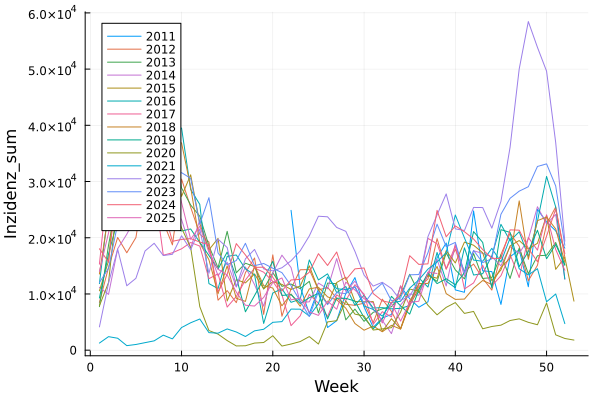

In [5]:
transform!(sum_ili_df, :Kalenderwoche => ByRow(w -> begin
        y, wstr = split(w, "-W")
        (parse(Int, y), parse(Int, wstr))
    end) => [:year, :week])

# 2. Create the plot grouped by :year
plot()
for y in sort(unique(sum_ili_df.year))
    sub = sum_ili_df[sum_ili_df.year .== y, :]
    plot!(sub.week, sub.Inzidenz_sum, label = string(y))
end

xlabel!("Week")
ylabel!("Inzidenz_sum")

In [6]:
# incidence data so population of 100.000
N0 = 100000

100000

## Seasonaility in infection rate
We use seasonality given by a Gaussian function as in https://doi.org/10.1016/j.epidem.2011.04.002.

From their equation 2, we take the form
$$
\beta(t)=\beta_i\left[\sum_i \left(\rho_i+(1-\rho_i)\frac{g(t-t_i,\sigma_i)}{g(0,\sigma_i)}\zeta(t,t_i)\right)\right]
$$
where 
- $\beta_i$ is the peak transmission coefficient for season $i$
- $(1-\rho_i)$ is the fraction by which transmission varies seasonally in season $i$
- $t_i$ is the day of peak transmission for season $i$
- season gets joined via $\zeta(t,t_i)$ with a apodization window of $\pm 30$ days.
- $\sigma_i$ is the std. deviation of the Gaussian probability distribution function $g(x,\sigma_i)$

Where we assume no difference between seasons.

In [ ]:
simulation_function = pyimport("mem_ssirs_joined")["ssirs_model"]

PyObject <function simple_ssirs at 0x7fca2d4e4720>

In [12]:
N0 = 100000
selected_ili_df = CSV.read("./data/ILI_germany_2016_2019.csv", DataFrame);
tobs = selected_ili_df.time.*7 # make sure that time is in weeks in data such that this transforms to days.
observations = selected_ili_df.Inzidenz_sum;

### Estimating seasons
We keep the Peakday and Sigma from the Gaussian fits but estimate the other paramers $\beta, T_E, T_I$ and the three $\rho_i$ for the influence of the i-th season.

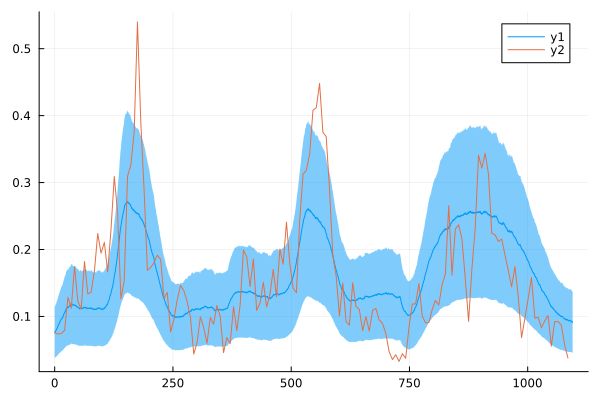

In [ ]:
p = [0.11, 7, 16, 0.28235, 0.26974, 0.2752]

testp = [0.1, 7, 16, 0.28235, 0.35, 0.23]

sigma = 0.5

N0 = 100000.0
I0 = selected_ili_df.Inzidenz_sum[1]
R0 = 20000.0
t_initial = 0.0
# u0 in the ordering [S, I, R]
u_initial = [N0-I0-R0, I0, R0]


t_end = 1095 # 3 years
sim = simulation_function(testp, u_initial, t_initial, t_end) 
days = sim[1,:]
infc = sim[3,:];

plt = plot(days, infc./N0, ribbon=sigma .* infc./N0)
plot!(plt, selected_ili_df.time*7, selected_ili_df.Inzidenz_sum./N0)

In [ ]:
ssirs_simulator = MemSSIRSSimulator(simulation_function, p, t_initial, u_initial)

MemSSIRSSimulator{Vector{Float64}}(PyObject <function simple_ssirs at 0x7fd3fcbf4720>, [0.11, 7.0, 16.0, 0.28235, 0.26974, 0.2752], 0.0, 0.0, [72431.0, 7569.0, 20000.0], [72431.0, 7569.0, 20000.0])

In [ ]:
# get observation function
function calc_log_obs_prob(x, y, t)
    y = collect(skipmissing(y))
    return logpdf(Normal(x[2], x[2]*sigma), y)[1]
end

calc_log_obs_prob (generic function with 1 method)

In [ ]:
nparticles = 50

function log_likelihood(θ)
    # Update the parameters in the simulator
    ssirs_simulator = MemSSIRSSimulator(simulation_function, θ, t_initial, u_initial)

    # Initialize the BootstrapFilter
    bf = BootstrapFilter(
        ssirs_simulator, calc_log_obs_prob, tobs, observations, nparticles
    )

    # Run the filter
    log_likeli = run_filter(bf)

    # Return the log-likelihood
    return log_likeli
end

bf = BootstrapFilter(
    ssirs_simulator, calc_log_obs_prob, tobs, observations, nparticles
    )

insupport(θ) = θ[1] > 0 && θ[2] > 0
logdensity(θ) = insupport(θ) ? log_likelihood(θ) : -Inf


logdensity (generic function with 1 method)

In [ ]:
logdensity(testp)

-1585.403125609203

In [ ]:
pypesto = pyimport("pypesto")

# convert PyPesto result to MCMCChains.jl chain type
function Chains_from_pypesto(result; kwargs...)
    trace_x = result.sample_result["trace_x"] # parameter values
    trace_neglogp = result.sample_result["trace_neglogpost"] # posterior values
    samples = Array{Float64}(undef, size(trace_x, 2), size(trace_x, 3) + 1, size(trace_x, 1))
    samples[:, begin:end-1, :] .= PermutedDimsArray(trace_x, (2, 3, 1))
    samples[:, end, :] = .-PermutedDimsArray(trace_neglogp, (2, 1))
    param_names = Symbol.(result.problem.x_names)
    chain = Chains(
        samples,
        vcat(param_names, :lp),
        (parameters = param_names, internals = [:lp]);
        kwargs...
    )
    return chain
end

neg_llh(θ) = -logdensity(θ)

# transform to pypesto objective
objective = pypesto.Objective(fun=neg_llh)

# create pypesto problem
pypesto_problem = pypesto.Problem(
    objective,
    x_names=["beta", "tinfc", "timm", "season_1", "season_2", "season_3"], # parameter names
    lb=[0.01, 1.0, 1.0, 0.1, 0.1, 0.1], # parameter bounds
    ub=[0.5, 14, 50, 0.5, 0.5, 0.5], # NB for sampling it is usually better if you remap parameters to (-∞, ∞)
    copy_objective=false, # important
)

# specify sampler
pypesto_sampler = pypesto.sample.AdaptiveMetropolisSampler();

In [ ]:
nsamples = 500
x0 = Vector([0.05, 7, 14, 0.2, 0.2, 0.2])
function chain()
    result = pypesto.sample.sample(
                        pypesto_problem,
                        n_samples=nsamples,
                        x0=x0, # starting point
                        sampler=pypesto_sampler,
                        )
    return Chains_from_pypesto(result)
end

nchains = 1 # Number of chains to run, one per worker

chains_list = [chain() for i in 1:nchains]

chain_values = chains_list[1].value.data

# get the chains
for j in 2:nchains
    global chain_values
    chain_values = cat(chain_values, chains_list[j].value.data, dims=(3,3))
end

chs = MCMCChains.Chains(chain_values, [:beta, :tinfc, :timm, :season1, :season2, :season3, :lp])
complete_chain = set_section(chs, Dict(:parameters => [:beta, :tinfc, :timm, :season1, :season2, :season3], :internals => [:lp]))

using HDF5 
h5open("./output/SSIRS_joined_0.5sig_pypesto_1ch_50p_$(nsamples)s.h5", "w") do f
    write(f, complete_chain)
end

100%|████████████████████████████████████████| 500/500 [09:20<00:00,  1.12s/it]
Elapsed time: 558.9736598409997


In [ ]:
using NPZ

npzwrite("joined_samples_$(nsamples)_out.npy", complete_chain.value.data)

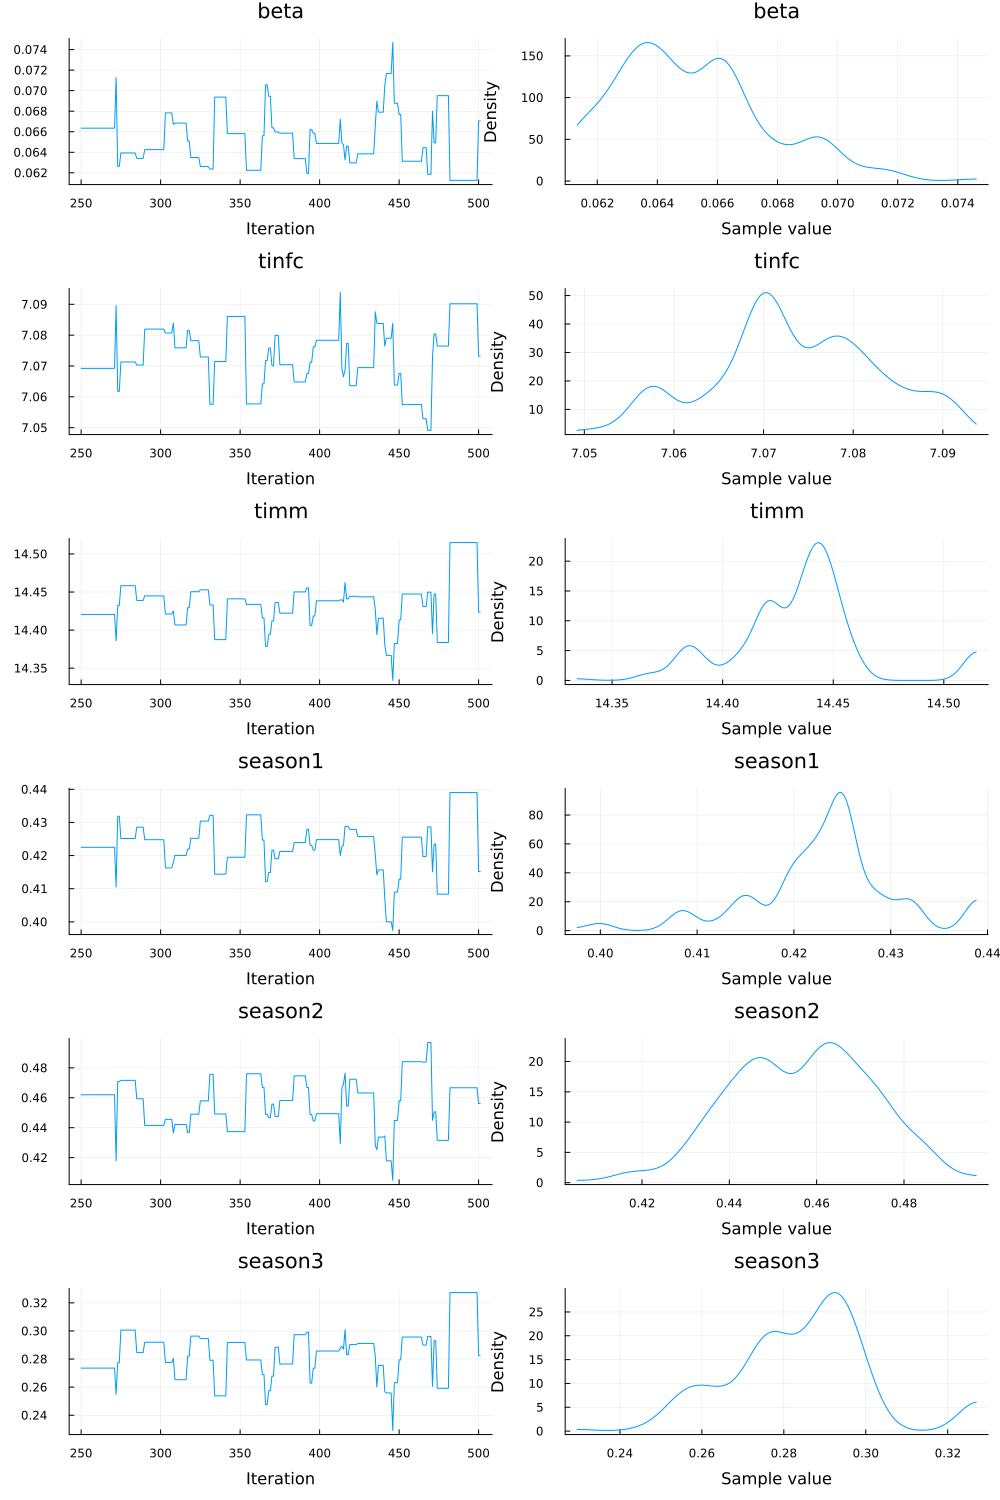

In [ ]:
mixed_chain = complete_chain[Int(nsamples/2):end]
plot(mixed_chain)

In [ ]:
mean_par = mean(mixed_chain).nt.mean
logdensity(mean_par)

-1574.1460127155426

In [ ]:
include("utilities.jl")

posterior_predictive_plot

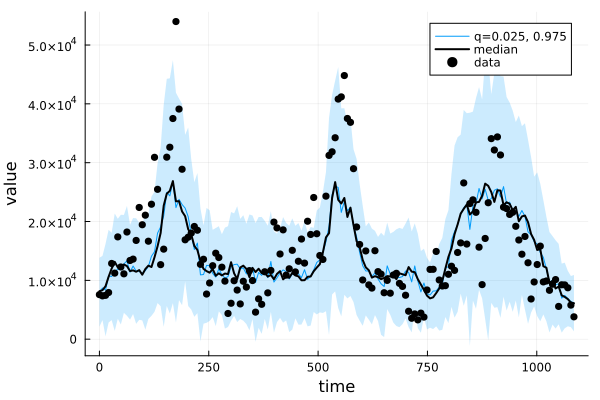

In [ ]:
# try visualization function
obs_t = selected_ili_df.time*7
obs_y = selected_ili_df.Inzidenz_sum;   

function simfun(par, tobs)
    full_sim = simulation_function(par, u_initial, tobs[1], tobs[end]) 
    tobs_ind = collect([findfirst(abs.(full_sim[1,:] .- tobs[i]) .< 0.001) for i in 1:length(tobs)]);
    obs_sim = full_sim[2:end, tobs_ind];
    noisy_sim = rand.(Normal.(obs_sim, 0.4 .* obs_sim))
    return noisy_sim
end

# reorder lp column to be first as expected by the plotting 
# test_vals = cat(zeros(100,1,1), repeat(reshape(testp, 1, 6, 1), 100, 1, 1); dims=2)
# plot_chain = MCMCChains.Chains(test_vals, [:lp, :beta, :tinfc, :timm, :season1, :season2, :season3])
plot_chain = MCMCChains.Chains(mixed_chain.value.data[:, [7, 1:6...],:], [:lp, :beta, :tinfc, :timm, :season1, :season2, :season3])
plot_chain = set_section(plot_chain, Dict(:internals => [:lp], :parameters => [:beta, :tinfc, :timm, :season1, :season2, :season3]))

res = posterior_predictive_plot(simfun, 
                                plot_chain, 
                                obs_t, 
                                obs_y;
                                n_ens = 100,
                                state = 2,
                                quantiles = (0.025, 0.5, 0.975))

display(res.plot)